# 1. Global methane levels from 2002

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# 1. 读取数据 + 确认单位及空值
# ===========================

file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
ds = xr.open_dataset(file_path)


var_name = "xch4"

methane = ds[var_name]

# 自动识别时间维度名
time_name = "time"
# ===============================
# 处理 fill_value = 1e20
# ===============================
fill_value_guess = 1e20
# 将 fill_value 替换为 NaN，并统一单位为ppb
methane = xr.where(methane > 1e19, np.nan, methane)
methane = methane * 1e9
methane.attrs["units"] = "ppb"


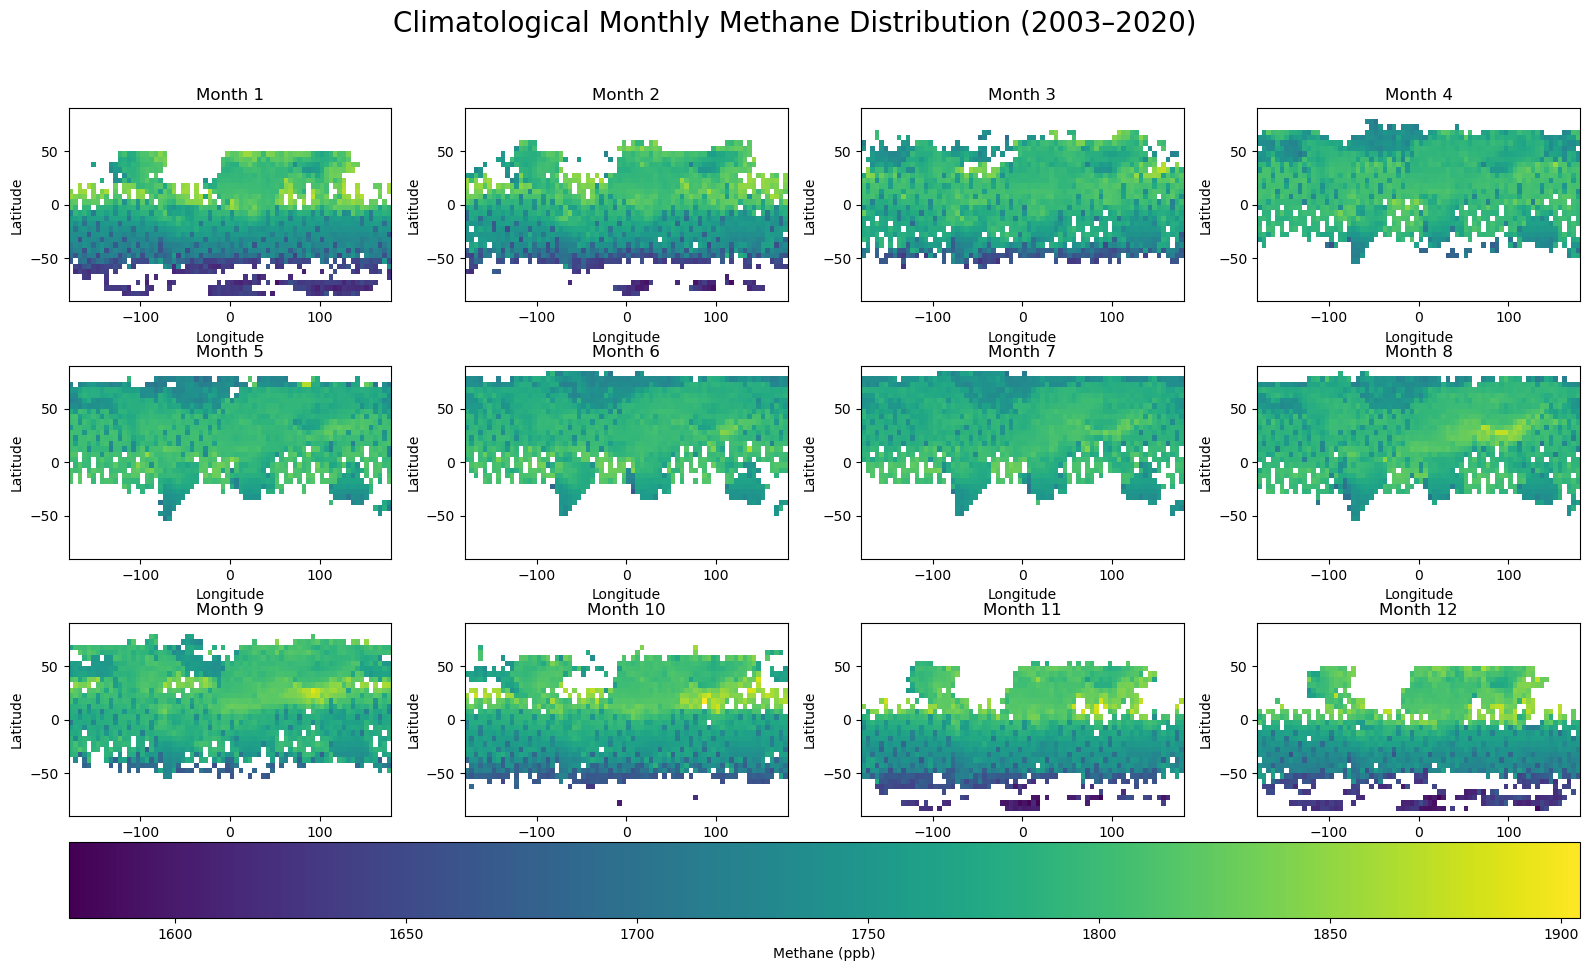

In [2]:
# ===========================
# 1.1 Climatology
# ===========================
climatology = methane.groupby(f"{time_name}.month").mean(skipna=True)

vmin = float(climatology.min())
vmax = float(climatology.max())

fig, axes = plt.subplots(3,4,figsize=(16,10))
axes = axes.flatten()

lon = ds["lon"]
lat = ds["lat"]

for i, ax in enumerate(axes, start=1):
    data = climatology.sel(month=i)
    im = ax.pcolormesh(lon, lat, data, shading="auto", cmap="viridis", vmin=vmin, vmax=vmax)
    ax.set_title(f"Month {i}", fontsize=12)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

fig.suptitle("Climatological Monthly Methane Distribution (2003–2020)", fontsize=20, y=1.02)
plt.tight_layout(rect=[0,0,1,1])
cbar = fig.colorbar(im, ax=axes, orientation="horizontal", pad=0.03)
cbar.set_label("Methane (ppb)")
# plt.show()
plt.savefig("1_1.jpg",dpi=600)

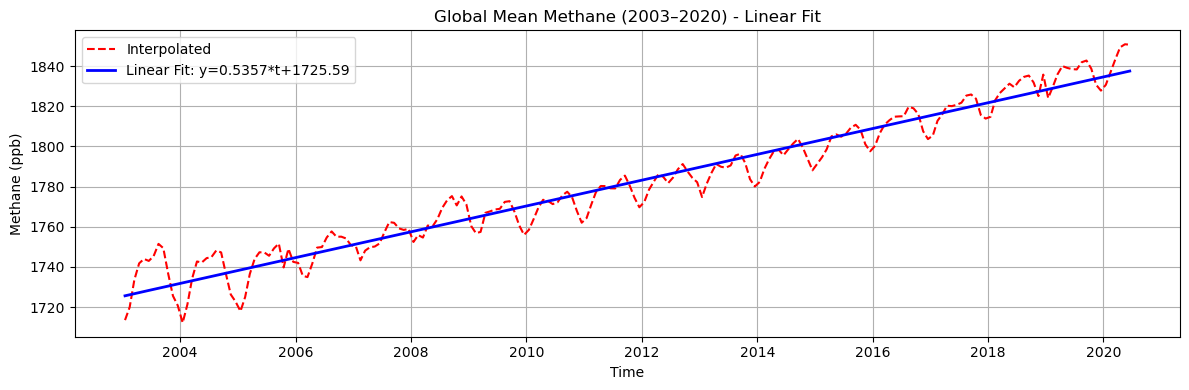

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

# ===========================
# 1.2 全球加权平均时间序列
# ===========================
# 面积权重
weights = np.cos(np.deg2rad(lat))
weights.name = "weights"
# ---------------------------
# 面积加权平均
# ---------------------------
global_mean = methane.weighted(weights).mean(("lat","lon"), skipna=True)
# 填充缺失值
global_mean_filled = global_mean.interpolate_na(dim=time_name)
# 转成 numpy array 用于拟合
y = global_mean_filled.values
x = np.arange(len(y))  # 时间索引
# ---------------------------
# 线性拟合
# ---------------------------
coef = np.polyfit(x, y, 1)      # 一阶多项式拟合 y = m*x + b
y_fit = np.polyval(coef, x)     # 拟合值
# ---------------------------
# 绘图
# ---------------------------
plt.figure(figsize=(12,4))
plt.plot(ds[time_name], y, linestyle='--', color='red', linewidth=1.5, label="Interpolated")
plt.plot(ds[time_name], y_fit, color='blue', linewidth=2, label=f"Linear Fit: y={coef[0]:.4f}*t+{coef[1]:.2f}")

plt.title("Global Mean Methane (2003–2020) - Linear Fit")
plt.xlabel("Time")
plt.ylabel("Methane (ppb)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# 保存高分辨率图片
plt.savefig("global_methane_linear_fit.jpg", dpi=600)
plt.show()


最近的格点（不考虑空值）: -12.5 -147.5
逐时间最近非空序列：NaN 数量 = 1


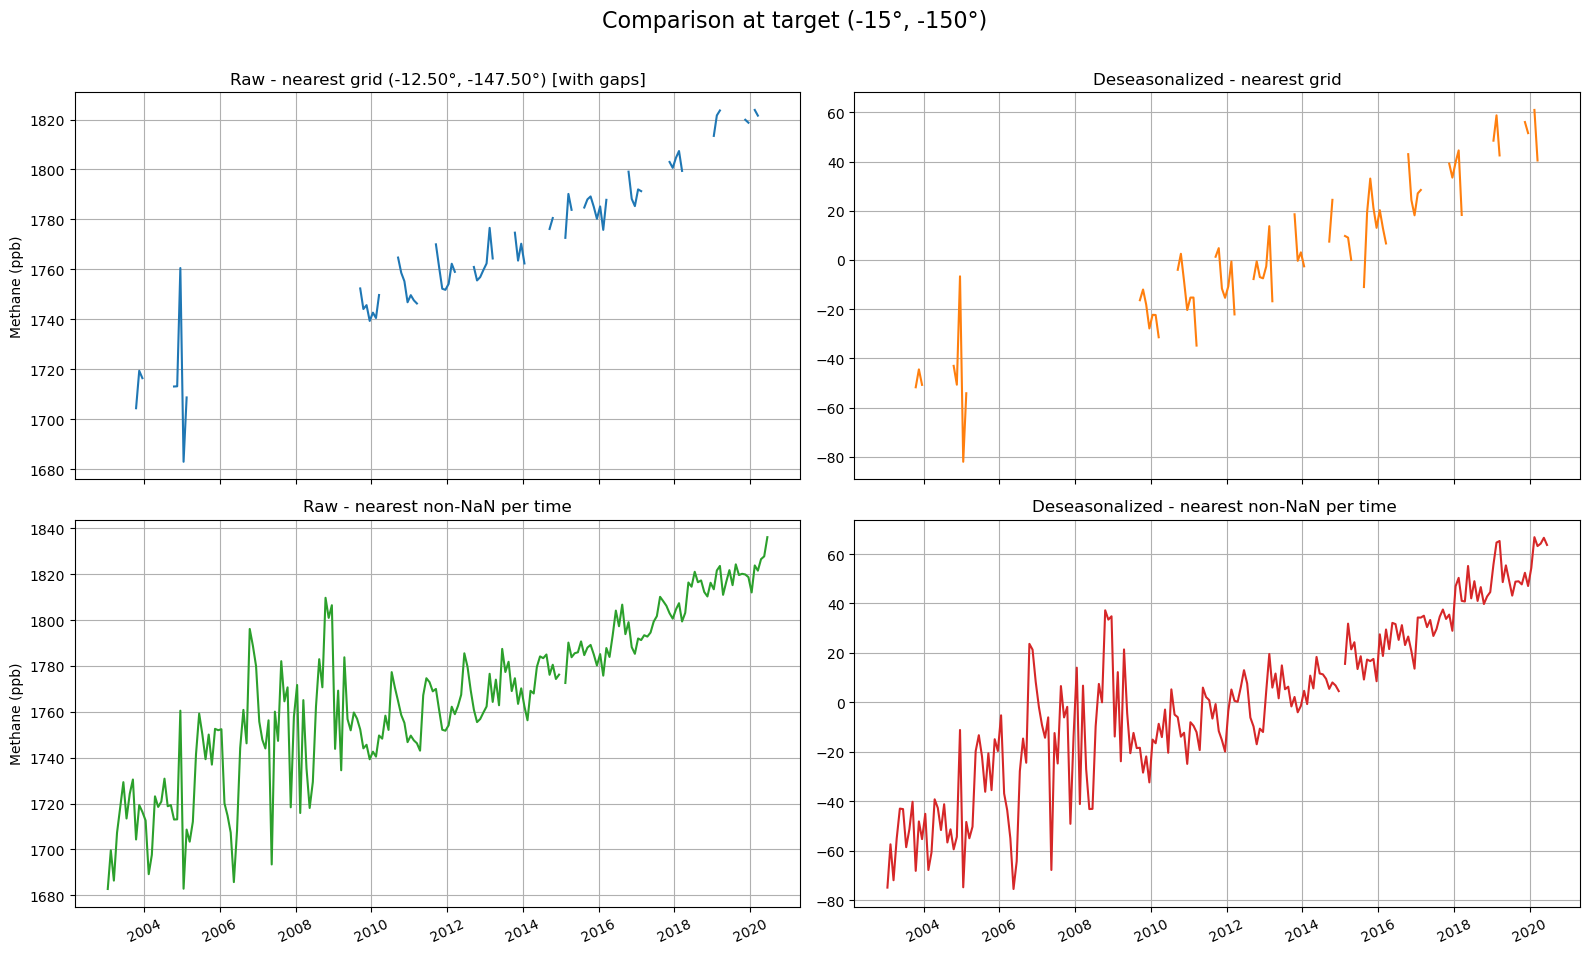

In [8]:
# ===========================
# 1.3 具体经纬度的时序数据图
# ===========================
# 完整代码：输出四图（nearest grid vs nearest non-NaN-per-time；原始 vs deseason）
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

def series_nearest_non_nan_per_time(meth_da, lat0, lon0):
    """
    对每个时间点，选择该时间切片中非 NaN 的点里距离 (lat0,lon0) 最近者，
    返回长度为 time 的 DataArray（与 meth_da.time 对齐）。
    """
    ntime = meth_da.sizes[time_name]
    out = np.full(ntime, np.nan, dtype=float)
    # 预计算欧氏距离矩阵（度为单位，适用于局部距离比较）
    dist = np.sqrt((LAT - lat0)**2 + (LON - lon0)**2)  # (nlat,nlon)
    # flatten indexing helper
    flat_idx_order = np.argsort(dist.ravel())  # indices of grid points sorted by distance (closest first)
    # for each time, find the closest cell with non-NaN value
    for i in range(ntime):
        slice_i = meth_da.isel({time_name: i}).values  # shape (nlat, nlon)
        if np.all(np.isnan(slice_i)):
            # whole slice empty
            out[i] = np.nan
            continue
        # find closest non-nan: use sorted indices until find non-nan
        found = False
        for flat_idx in flat_idx_order:
            j, k = np.unravel_index(flat_idx, slice_i.shape)
            val = slice_i[j, k]
            if not np.isnan(val):
                out[i] = val
                found = True
                break
        if not found:
            out[i] = np.nan
    # return as xarray DataArray aligned with time
    return xr.DataArray(out, coords={time_name: meth_da[time_name]}, dims=[time_name])


target_lat= -15
target_lon =-150
# ------------- 1) 最近格点（直接 nearest，不管空不空） -------------
nearest_lat = float(lat.sel(lat=target_lat, method="nearest").values)
nearest_lon = float(lon.sel(lon=target_lon, method="nearest").values)
print("最近的格点（不考虑空值）:", nearest_lat, nearest_lon)
series_nearest = methane.sel(lat=nearest_lat, lon=nearest_lon)  # (time,)

# ------------- 2) 对每个时间点找最近的非空值（逐时间搜索） -------------
# 把经纬度做成网格用于距离计算（注意 lon,lat 的顺序）
LAT, LON = np.meshgrid(lat.values, lon.values, indexing='ij')  # shapes (nlat, nlon)
series_nn_per_time = series_nearest_non_nan_per_time(methane, target_lat, target_lon)

print("逐时间最近非空序列：NaN 数量 =", int(series_nn_per_time.isnull().sum().values))

# ------------- 3) 为两条序列分别计算 climatology (按月) 并去季节化 -------------
# 用 month grouper
months = methane[time_name].dt.month

clim_nearest = series_nearest.groupby(months).mean()          # month dimension
deseason_nearest = series_nearest.groupby(months) - clim_nearest

clim_nn_per_time = series_nn_per_time.groupby(months).mean()
deseason_nn_per_time = series_nn_per_time.groupby(months) - clim_nn_per_time


# ------------- 4) 绘图：2x2 (原始/去季节 × nearest / nearest-non-nan) -------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
(ax1, ax2), (ax3, ax4) = axes

# Top-left: 原始最近格点（保留 NaN，会断线）
ax1.plot(ds[time_name], series_nearest, label="nearest grid (raw)", color="C0")
ax1.set_title(f"Raw - nearest grid ({nearest_lat:.2f}°, {nearest_lon:.2f}°) [with gaps]")
ax1.set_ylabel("Methane (ppb)")
ax1.grid(True)

# Top-right: 去季节化最近格点（保留 NaN）
ax2.plot(ds[time_name], deseason_nearest, label="deseason - nearest grid", color="C1")
ax2.set_title("Deseasonalized - nearest grid")
ax2.grid(True)

# Bottom-left: 原始最近非空逐时序
ax3.plot(ds[time_name], series_nn_per_time.values, label="nearest non-NaN per time", color="C2")
ax3.set_title("Raw - nearest non-NaN per time")
ax3.set_ylabel("Methane (ppb)")
ax3.grid(True)

# Bottom-right: 去季节化最近非空逐时序 
ax4.plot(ds[time_name], deseason_nn_per_time.values, label="deseason nn per time", color="C3")
ax4.set_title("Deseasonalized - nearest non-NaN per time ")
ax4.grid(True)

# cosmetics
for ax in axes.ravel():
    ax.tick_params(axis="x", rotation=25)
fig.suptitle(f"Comparison at target ({target_lat}°, {target_lon}°)", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
# plt.show()

plt.savefig("1_3.jpg",dpi=600)

# 2 Niño 3.4 index

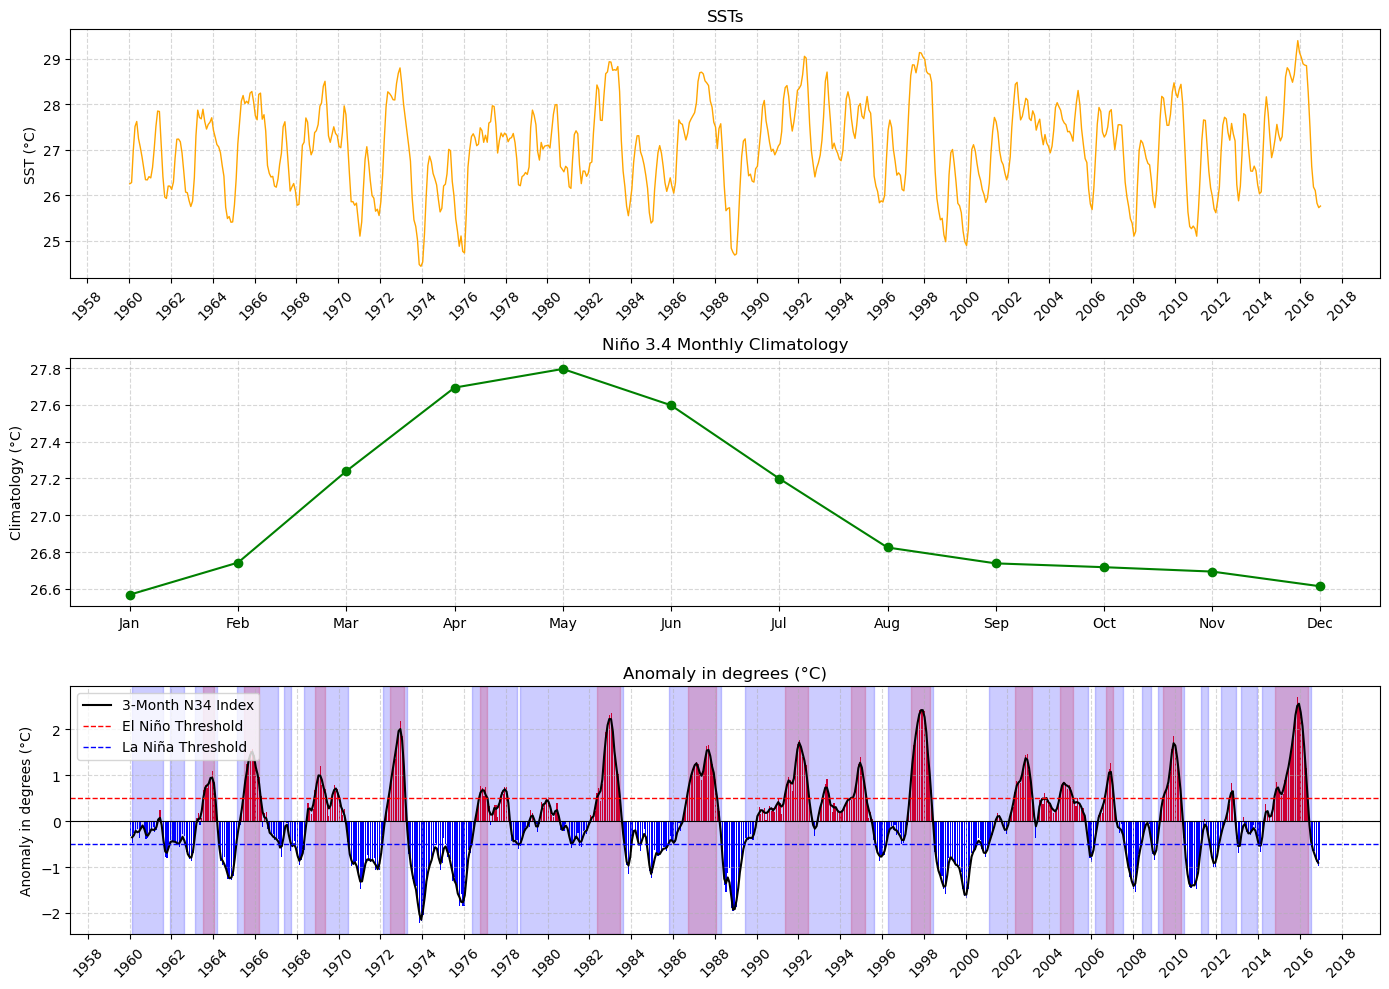

In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# ===============================
# 1. Load Data
# ===============================
ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc")
sst = ds["sst"]
lat = ds["lat"]
lon = ds["lon"]

# ===============================
# 2. Select Niño 3.4 Region (5N–5S, 170W–120W = lon 190–240)
# ===============================
sst_n34 = sst.sel(lat=slice(-5, 5), lon=slice(190, 240)).mean(dim=["lat","lon"])

# ===============================
# 3. Monthly Climatology
# ===============================
climatology = sst_n34.groupby("time.month").mean("time")

# ===============================
# 4. Anomalies
# ===============================
anomaly = sst_n34.groupby("time.month") - climatology

# ===============================
# 5. 3-month Running Mean Niño 3.4 Index
# ===============================
n34_index = anomaly.rolling(time=3, center=True).mean()

# ===============================
# 6. Convert to pandas Series
# ===============================
dates = pd.to_datetime(n34_index["time"].values)
n34_series = pd.Series(n34_index.values, index=dates)

anomaly_series = pd.Series(anomaly.values, index=pd.to_datetime(anomaly["time"].values))
sst_series = pd.Series(sst_n34.values, index=pd.to_datetime(sst_n34["time"].values))

# ===============================
# 7. El Niño / La Niña detection
# ===============================
def find_events(series, threshold):
    above = series >= threshold
    events = []
    start = None
    for i in range(len(series)):
        if above.iloc[i] and start is None:
            start = i
        elif not above.iloc[i] and start is not None:
            if i - start >= 5:
                events.append((series.index[start], series.index[i-1]))
            start = None
    if start is not None and len(series)-start >= 5:
        events.append((series.index[start], series.index[-1]))
    return events

el_nino = find_events(n34_series, 0.5)
la_nina = find_events(n34_series, -0.5)

# ===============================
# 8. Plotting (Modified)
# ===============================

fig, axes = plt.subplots(3,1, figsize=(14,10))  # 合并第三、第四图，原第二图保持
# --------- 1 Raw SST ---------
axes[0].plot(sst_series.index, sst_series.values, lw=1, color='orange')
axes[0].set_ylabel("SST (°C)")
axes[0].set_title("SSTs")
axes[0].grid(True, linestyle='--', alpha=0.5)

# --------- 2 Climatology ---------
months = np.arange(1, 13)
axes[1].plot(months, climatology.values, marker='o', color='green')
axes[1].set_xticks(months)
axes[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                         'Jul','Aug','Sep','Oct','Nov','Dec'])
axes[1].set_ylabel("Climatology (°C)")
axes[1].set_title("Niño 3.4 Monthly Climatology")
axes[1].grid(True, linestyle='--', alpha=0.5)

# --------- 3 Combined Anomaly Histogram + N34 Index ---------
# Histogram for anomaly
pos = anomaly_series[anomaly_series >= 0]
neg = anomaly_series[anomaly_series < 0]

axes[2].bar(pos.index, pos.values, color='red', width=20, label='')
axes[2].bar(neg.index, neg.values, color='blue', width=20, label='')

# Overlay N34 Index
axes[2].plot(n34_series.index, n34_series.values, lw=1.5, color='black', label='3-Month N34 Index')

# Threshold lines
axes[2].axhline(0, color='k', lw=0.8)
axes[2].axhline(0.5, color='r', linestyle='--', lw=1, label='El Niño Threshold')
axes[2].axhline(-0.5, color='b', linestyle='--', lw=1, label='La Niña Threshold')

# Shade events
for start,end in el_nino:
    axes[2].axvspan(start, end, color='red', alpha=0.2)
for start,end in la_nina:
    axes[2].axvspan(start, end, color='blue', alpha=0.2)

axes[2].set_ylabel("Anomaly in degrees (°C)")
axes[2].set_title("Anomaly in degrees (°C)")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend(loc='upper left')

# --------- X-axis formatting ---------
for ax in [axes[0], axes[2]]:
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
# plt.show()
plt.savefig("2_1.jpg",dpi=600)


# 3. Explore a netCDF dataset

In [12]:
# ===========================================
# 0. Import packages
# ===========================================
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ===========================================
# 1. Load dataset
# ===========================================
file_path = "CMSFluxLandPrior201001_202212_v3.nc"
ds = xr.open_dataset(file_path,decode_times=False)

# Extract variables
nbe = ds["NBE_prior"]        # (time, lat, lon)
lat = ds["latitude"]
lon = ds["longitude"]
time = ds["time"]

# print(ds)
print(nbe.attrs)


{'units': 'g/m^2/day', 'long_name': 'Net biosphere exchange prior from CARDAMOM model,unit:gram carbon per square meter per day'}


In [13]:
#  2. Convert time coordinate to real dates

ds['time'] = xr.cftime_range(start='2010-01-15', periods=ds.sizes['time'], freq='MS')
nbe = ds["NBE_prior"]
nbe = nbe.where(nbe != 0)
# 3. 计算全球平均 
# Load area (m^2)
area = ds["area"]

# mask zero or negative area
valid_area = area.where(area > 0)

# Weighted global mean time series
global_mean = (nbe * valid_area).sum(dim=["latitude","longitude"]) / valid_area.sum()

# 4. 去除月季节循环（monthly climatology）→ anomaly
# Compute monthly climatology
clim = global_mean.groupby("time.month").mean("time")

# Remove seasonal cycle
anomaly = global_mean.groupby("time.month") - clim


C:\Users\ruyik\AppData\Local\Temp\ipykernel_32400\2618761718.py:3: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  ds['time'] = xr.cftime_range(start='2010-01-15', periods=ds.sizes['time'], freq='MS')


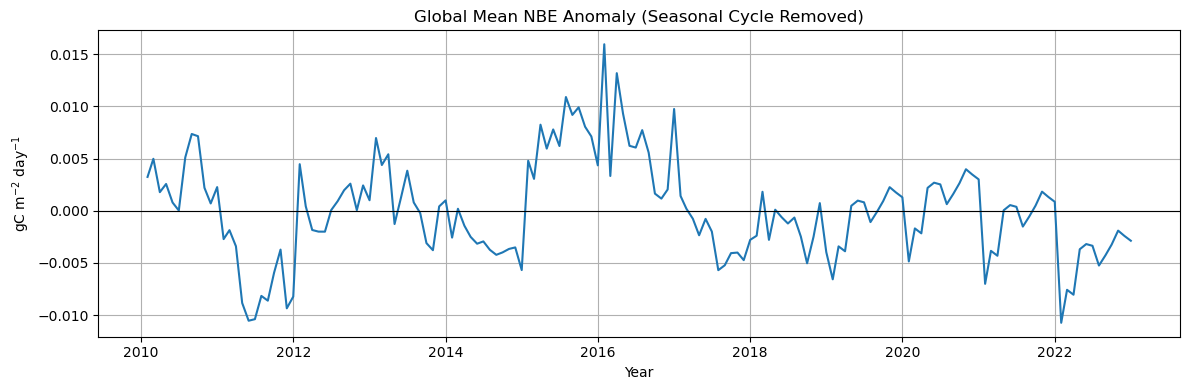

In [14]:
# ================================================
#  3.1 图：Global mean NBE (seasonal cycle removed)
# ================================================

# Convert cftime → numpy datetime64 for matplotlib
time_numpy = pd.to_datetime(ds.time.astype(str))

plt.figure(figsize=(12,4))
plt.plot(time_numpy, anomaly, label="NBE Anomaly")

plt.axhline(0, color='k', linewidth=0.8)
plt.title("Global Mean NBE Anomaly (Seasonal Cycle Removed)")
plt.xlabel("Year")
plt.ylabel(r"gC m$^{-2}$ day$^{-1}$")
plt.grid(True)

plt.tight_layout()
# plt.show()
plt.savefig("3_1.jpg",dpi=600)

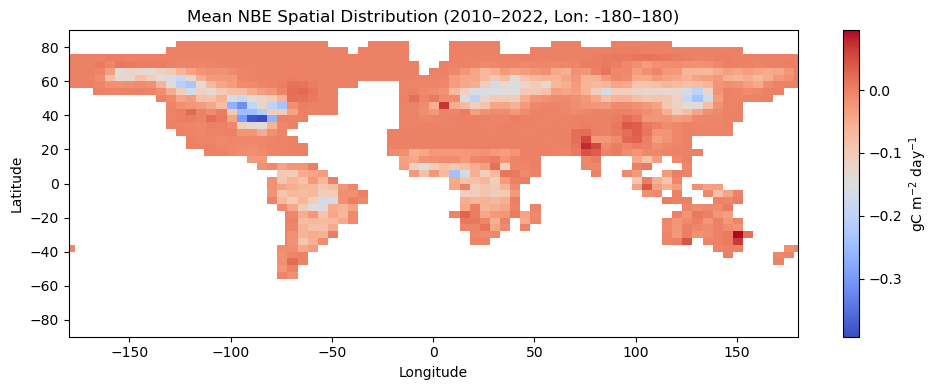

In [15]:
# ================================================
# 3.2 
# ================================================

# =======================================================
# 统一：经度从 0–360 转成 -180–180，并按经度排序
# =======================================================
lon_new = (((lon + 180) % 360) - 180)
nbe = nbe.assign_coords(longitude=lon_new)

# 排序（确保从 -180 到 180 顺序正确）
nbe = nbe.sortby("longitude")
# 新坐标变量
lat = nbe.latitude
lon = nbe.longitude

# ================================================
# 图1：多年平均空间分布
# ================================================
nbe_mean_map = nbe.mean(dim="time", skipna=True)

plt.figure(figsize=(10,4))
plt.pcolormesh(lon, lat, nbe_mean_map,
               cmap="coolwarm", shading="auto")

plt.colorbar(label=r"gC m$^{-2}$ day$^{-1}$")
plt.title("Mean NBE Spatial Distribution (2010–2022, Lon: -180–180)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
# plt.show()
plt.savefig("3_2.jpg",dpi=600)


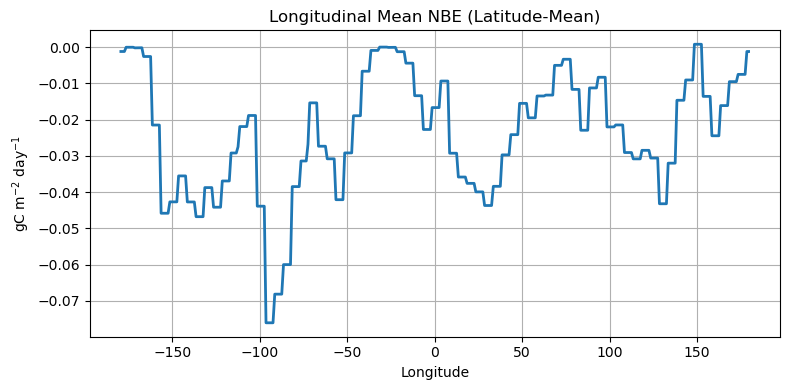

In [16]:
# -------------------------------
# 图 2：经度剖面（纬度平均）
# -------------------------------
nbe_lon_profile = nbe.mean(dim=("time", "latitude"))

plt.figure(figsize=(8,4))
plt.plot(lon, nbe_lon_profile, linewidth=2)
plt.title("Longitudinal Mean NBE (Latitude-Mean)")
plt.xlabel("Longitude")
plt.ylabel(r"gC m$^{-2}$ day$^{-1}$")
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig("3_3.jpg",dpi=600)

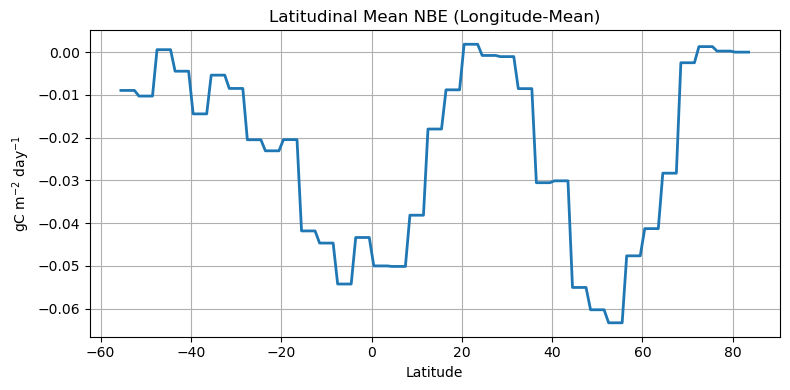

In [17]:
# -------------------------------
# 图 3：纬度剖面（经度平均）
# -------------------------------
nbe_lat_profile = nbe.mean(dim=("time", "longitude"))

plt.figure(figsize=(8,4))
plt.plot(lat, nbe_lat_profile, linewidth=2)
plt.title("Latitudinal Mean NBE (Longitude-Mean)")
plt.xlabel("Latitude")
plt.ylabel(r"gC m$^{-2}$ day$^{-1}$")
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig("3_4.jpg",dpi=600)

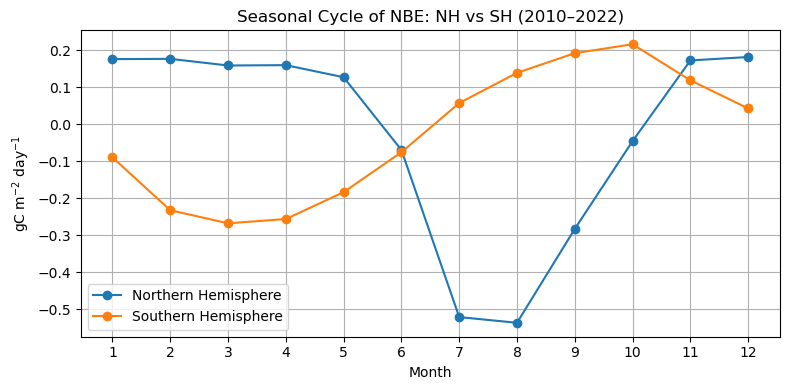

In [19]:
# ================================================
# 图 4：北半球 vs 南半球月季节循环
# ================================================

# NH: lat > 0；SH: lat < 0
nbe_NH = nbe.where(lat > 0).mean(dim=["latitude", "longitude"], skipna=True)
nbe_SH = nbe.where(lat < 0).mean(dim=["latitude", "longitude"], skipna=True)

# Monthly climatology
clim_NH = nbe_NH.groupby("time.month").mean()
clim_SH = nbe_SH.groupby("time.month").mean()

plt.figure(figsize=(8,4))
plt.plot(clim_NH.month, clim_NH, label="Northern Hemisphere", marker="o")
plt.plot(clim_SH.month, clim_SH, label="Southern Hemisphere", marker="o")

plt.grid(True)
plt.xticks(range(1,13))
plt.xlabel("Month")
plt.ylabel(r"gC m$^{-2}$ day$^{-1}$")
plt.title("Seasonal Cycle of NBE: NH vs SH (2010–2022)")
plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig("3_5.jpg",dpi=600)

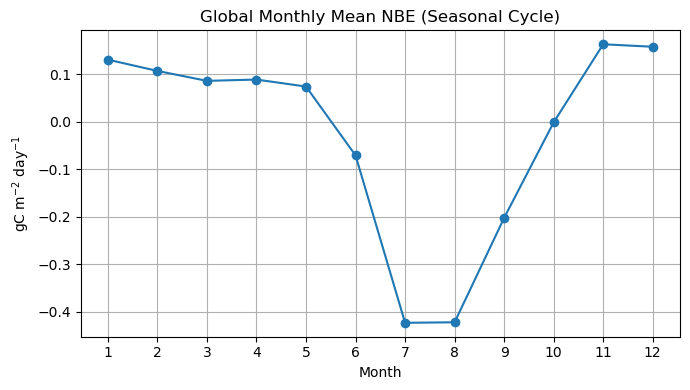

In [20]:
# -------------------------------
# 图 5：NBE 的全球季节循环（12 个月平均）
# -------------------------------
# 先按 calendar month 分组
nbe_month = nbe.groupby("time.month").mean(dim=("time", "latitude", "longitude"))

plt.figure(figsize=(7,4))
plt.plot(range(1,13), nbe_month, marker='o')
plt.xticks(range(1,13))
plt.title("Global Monthly Mean NBE (Seasonal Cycle)")
plt.xlabel("Month")
plt.ylabel(r"gC m$^{-2}$ day$^{-1}$")
plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig("3_6.jpg",dpi=600)

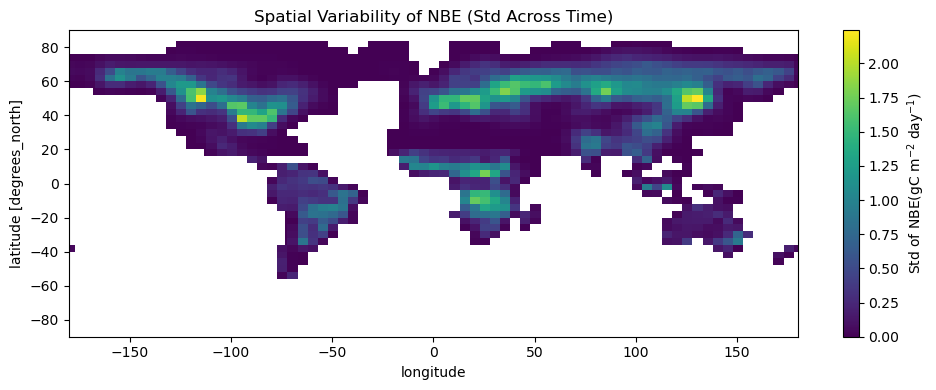

In [21]:
# -------------------------------
# 图 6：NBE 变率（标准差）空间分布
# -------------------------------
nbe_std = nbe.std(dim="time")

plt.figure(figsize=(10,4))
nbe_std.plot(
    cmap="viridis",
    cbar_kwargs={'label': r"Std of NBE(gC m$^{-2}$ day$^{-1}$)"}
)
plt.title("Spatial Variability of NBE (Std Across Time)")
plt.tight_layout()
# plt.show()
plt.savefig("3_7.jpg",dpi=600)